In [6]:
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
file_path = '/content/drive/MyDrive/SpeechTechnologies/AEG_1934.mp3'
data, samplerate = sf.read(file_path)

data.shape, samplerate


((7797760, 2), 44100)

In [12]:
print(f"Количество каналов: {data.shape[1]}")
print(f"Длительность: {data.shape[0] / samplerate:.2f} секунд")

Количество каналов: 2
Длительность: 176.82 секунд


In [13]:
time = np.arange(len(data)) / samplerate
time

array([0.00000000e+00, 2.26757370e-05, 4.53514739e-05, ...,
       1.76819887e+02, 1.76819909e+02, 1.76819932e+02])

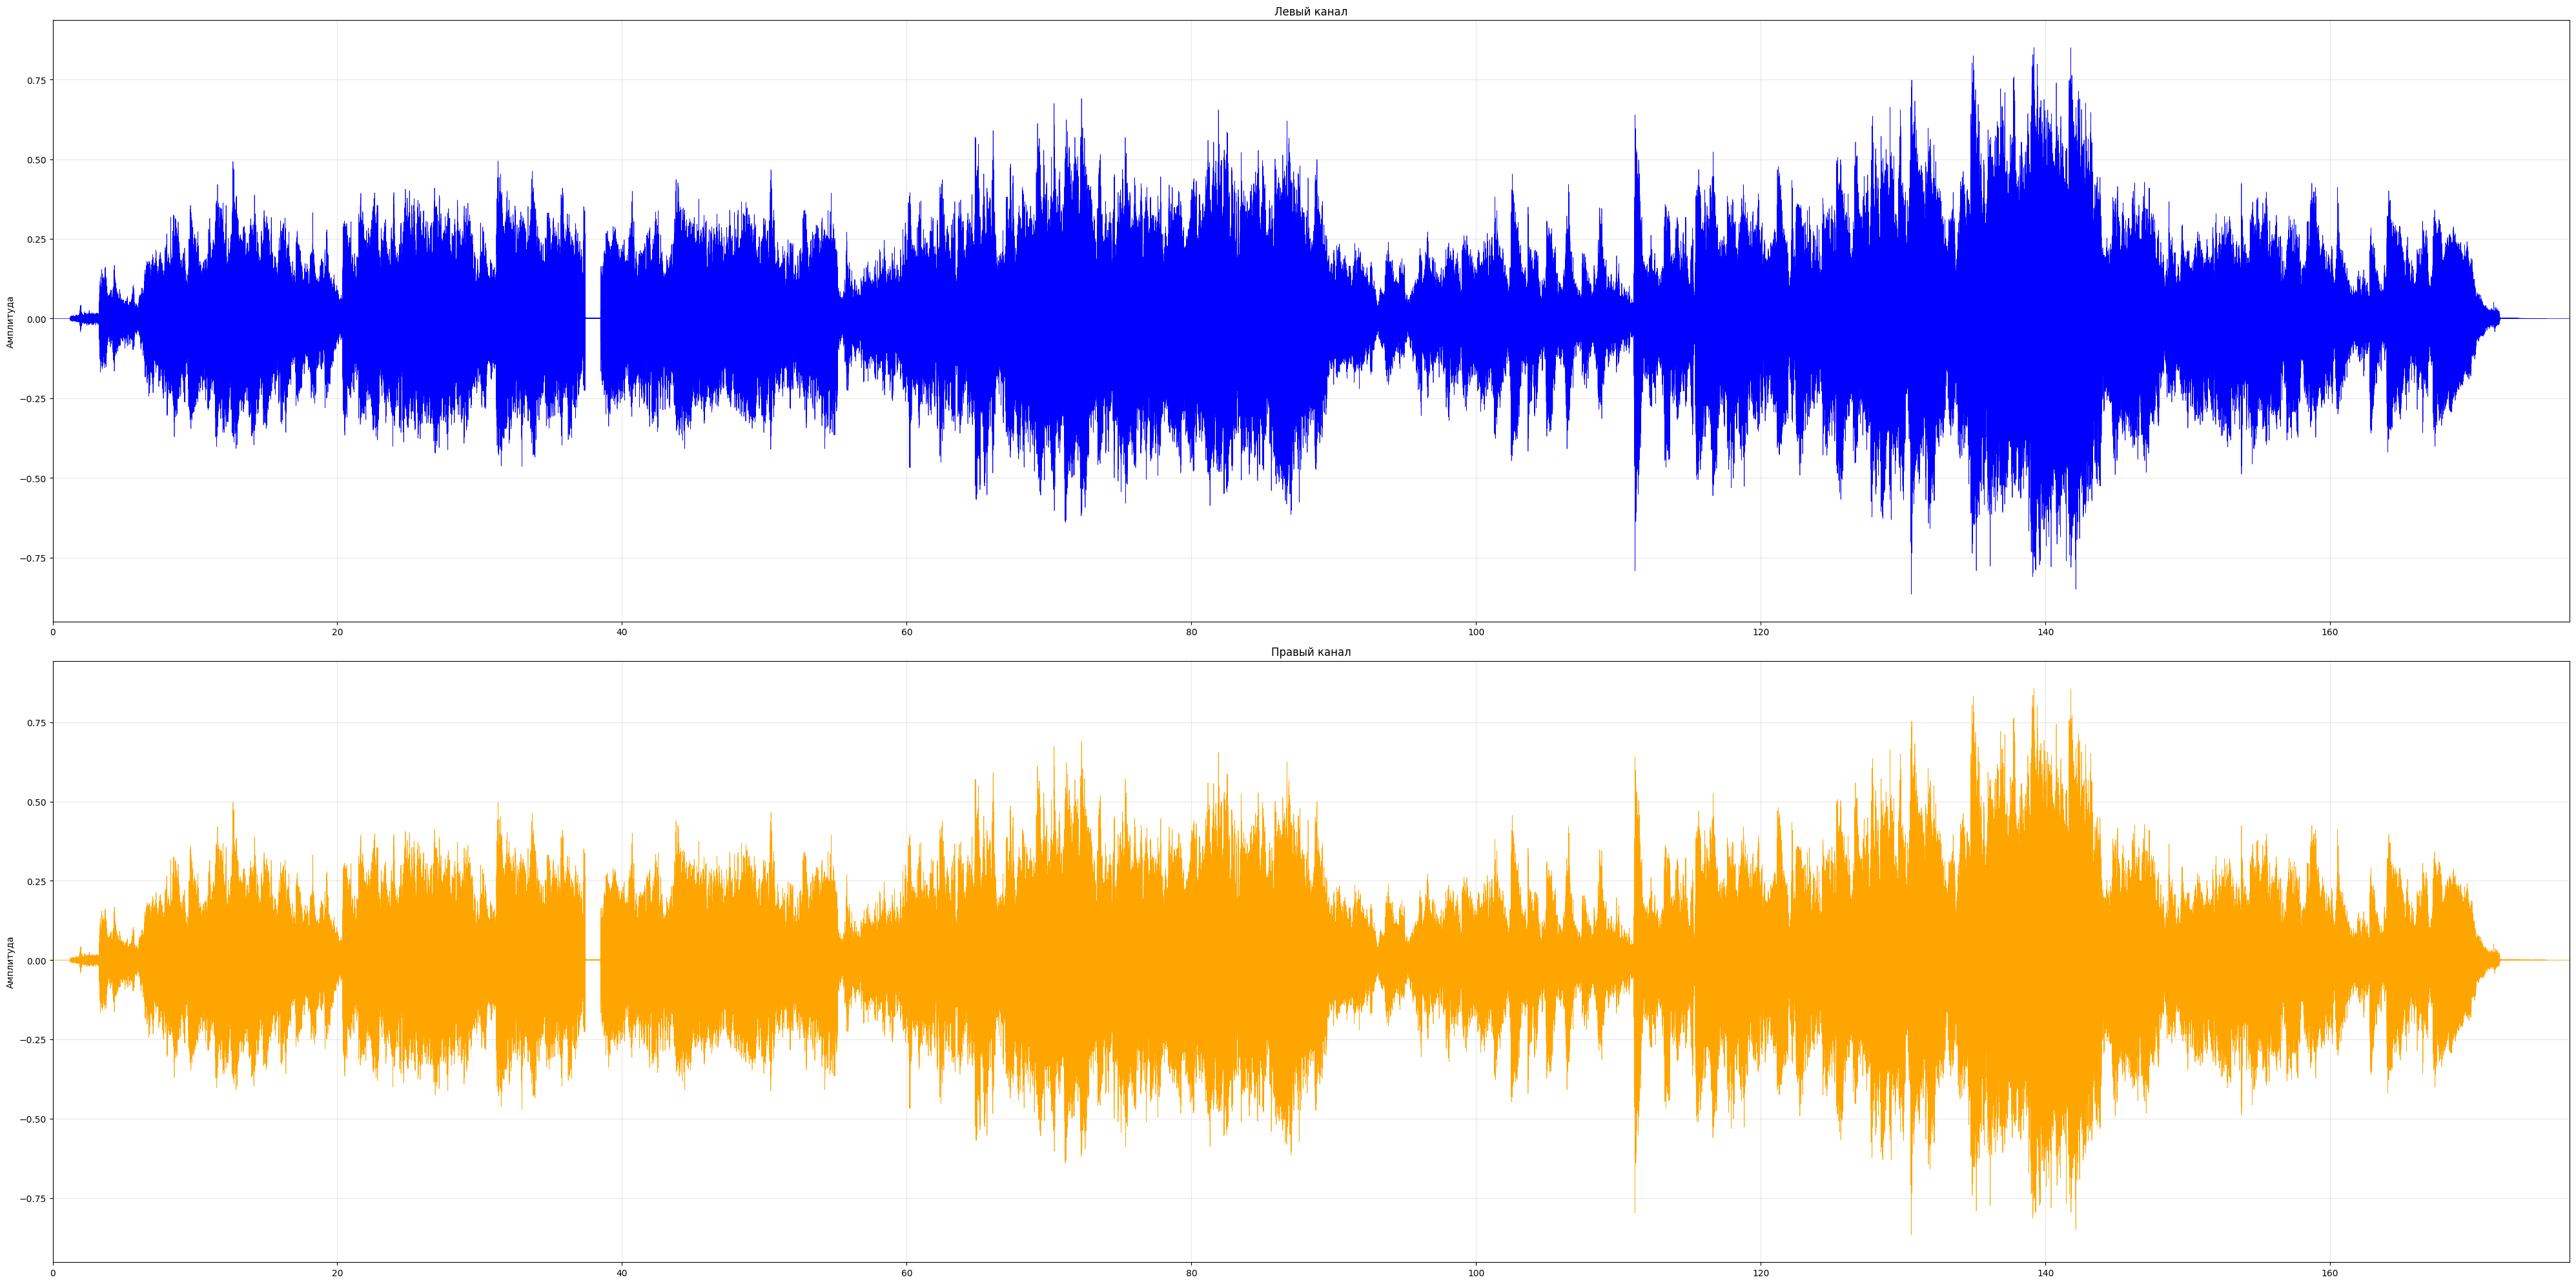

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(40, 20))

axes[0].plot(time, data[:, 0], color='blue', linewidth=0.5)
axes[0].set_title('Левый канал')
axes[0].set_ylabel('Амплитуда')
axes[0].set_xlim([time[0], time[-1]])
axes[0].grid(True, alpha=0.3)

axes[1].plot(time, data[:, 1], color='orange', linewidth=0.5)
axes[1].set_title('Правый канал')
axes[1].set_ylabel('Амплитуда')
axes[1].set_xlim([time[0], time[-1]])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
def compute_spectrogram(channel, n_fft, hop_length):
    n_frames = 1 + (len(channel) - n_fft) // hop_length
    spectrogram = np.zeros((n_fft // 2 + 1, n_frames), dtype=np.complex64)

    for i in range(n_frames):
        start = i * hop_length
        end = start + n_fft

        if end > len(channel):
            frame = np.zeros(n_fft)
            frame[:len(channel)-start] = channel[start:]
        else:
            frame = channel[start:end]

        window = np.hanning(n_fft)
        windowed_frame = frame * window
        spectrogram[:, i] = np.fft.rfft(windowed_frame, n=n_fft)
    return spectrogram


def spec_to_db(spectrogram, is_db_=False):
    """Преобразуем комплексную спектрограмму в децибелы"""
    amplitude = np.abs(spectrogram)
    amplitude = np.maximum(amplitude, 1e-10)
    if is_db_:
        amplitude = 20 * np.log10(amplitude)
    return amplitude

Применим быстрое преобразование Фурье

In [16]:
frame_size = 2_048
hop_length = 512
n_fft = 2_048
n_mels = 100
fmin = 0
fmax = 10_000 # Так как запись старая. Маловероятно, что в частотах от 10кГц будет важная информация

left_channel = data[:, 0]
right_channel = data[:, 1]

spec_left = compute_spectrogram(left_channel, n_fft, hop_length)
spec_right = compute_spectrogram(right_channel, n_fft, hop_length)

print(spec_left.shape, spec_right.shape)

spec_left_db = spec_to_db(spec_left, True)
spec_right_db = spec_to_db(spec_right, True)

print(spec_left_db.shape, spec_right_db.shape)

(1025, 15227) (1025, 15227)
(1025, 15227) (1025, 15227)


Визуализируем

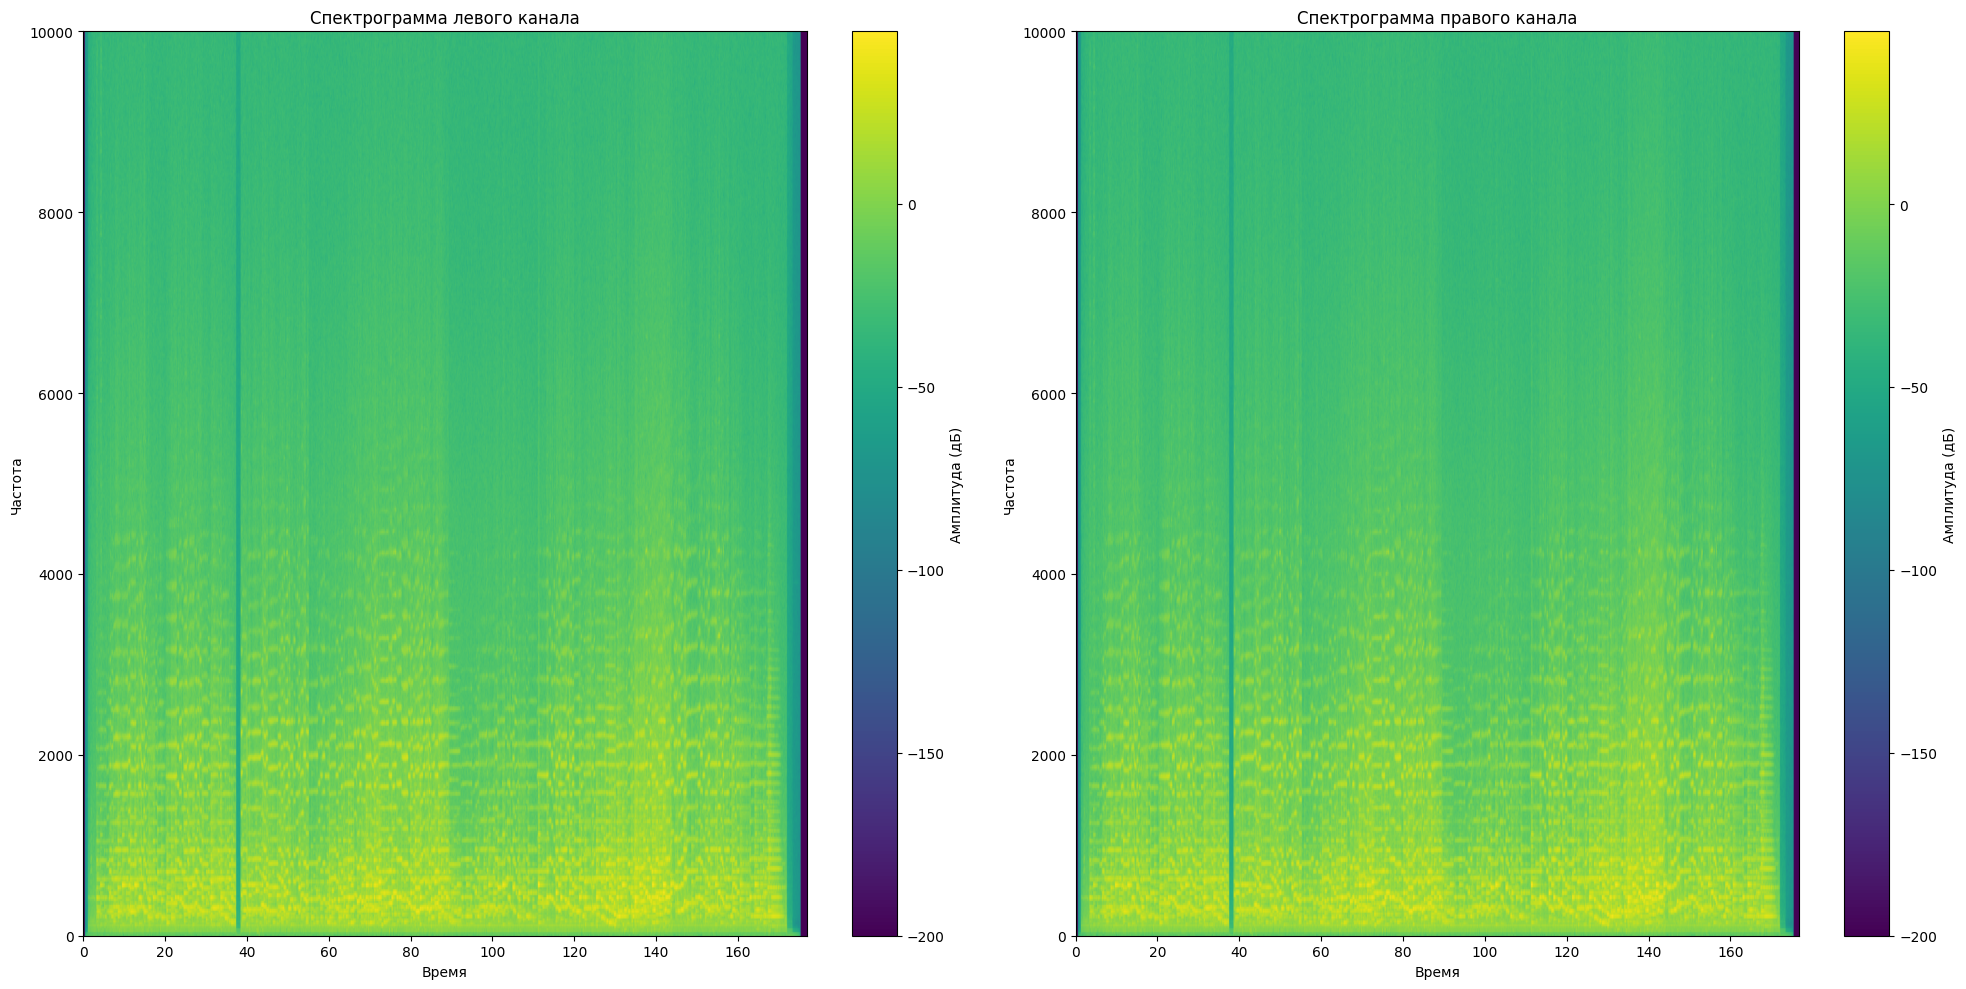

In [17]:

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

time_axis = np.arange(spec_left_db.shape[1]) * hop_length / samplerate  # время
freq_axis = np.fft.rfftfreq(n_fft, d=1/samplerate)  # частоты

im_left = axes[0].imshow(spec_left_db,
                           aspect='auto',
                           origin='lower',
                           extent=[time_axis[0], time_axis[-1],
                                   freq_axis[0], freq_axis[-1]])
axes[0].set_title('Спектрограмма левого канала')
axes[0].set_xlabel('Время')
axes[0].set_ylabel('Частота')
plt.colorbar(im_left, ax=axes[0], label='Амплитуда (дБ)')
axes[0].set_ylim([fmin, fmax])

im_right = axes[1].imshow(spec_right_db,
                            aspect='auto',
                            origin='lower',
                            extent=[time_axis[0], time_axis[-1],
                                    freq_axis[0], freq_axis[-1]])
axes[1].set_title('Спектрограмма правого канала')
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Частота')
plt.colorbar(im_right, ax=axes[1], label='Амплитуда (дБ)')
axes[1].set_ylim([fmin, fmax])

plt.tight_layout()
plt.show()

In [18]:
def hz_to_mel(freq):
    """Преобразование частоты в Герцах в MEL-шкалу"""
    return 2595 * np.log10(1 + freq / 700)

def mel_to_hz(mel):
    """Обратное преобразование"""
    return 700 * (10 ** (mel / 2595) - 1)

In [19]:
# Спектрограммы с амплитудами комплексных чисел
spec_left_amp = spec_to_db(spec_left, False)
spec_right_amp = spec_to_db(spec_right, False)

Функции для построения MEL-спектрограммы

(100, 1025)
(100, 15227) (100, 15227)


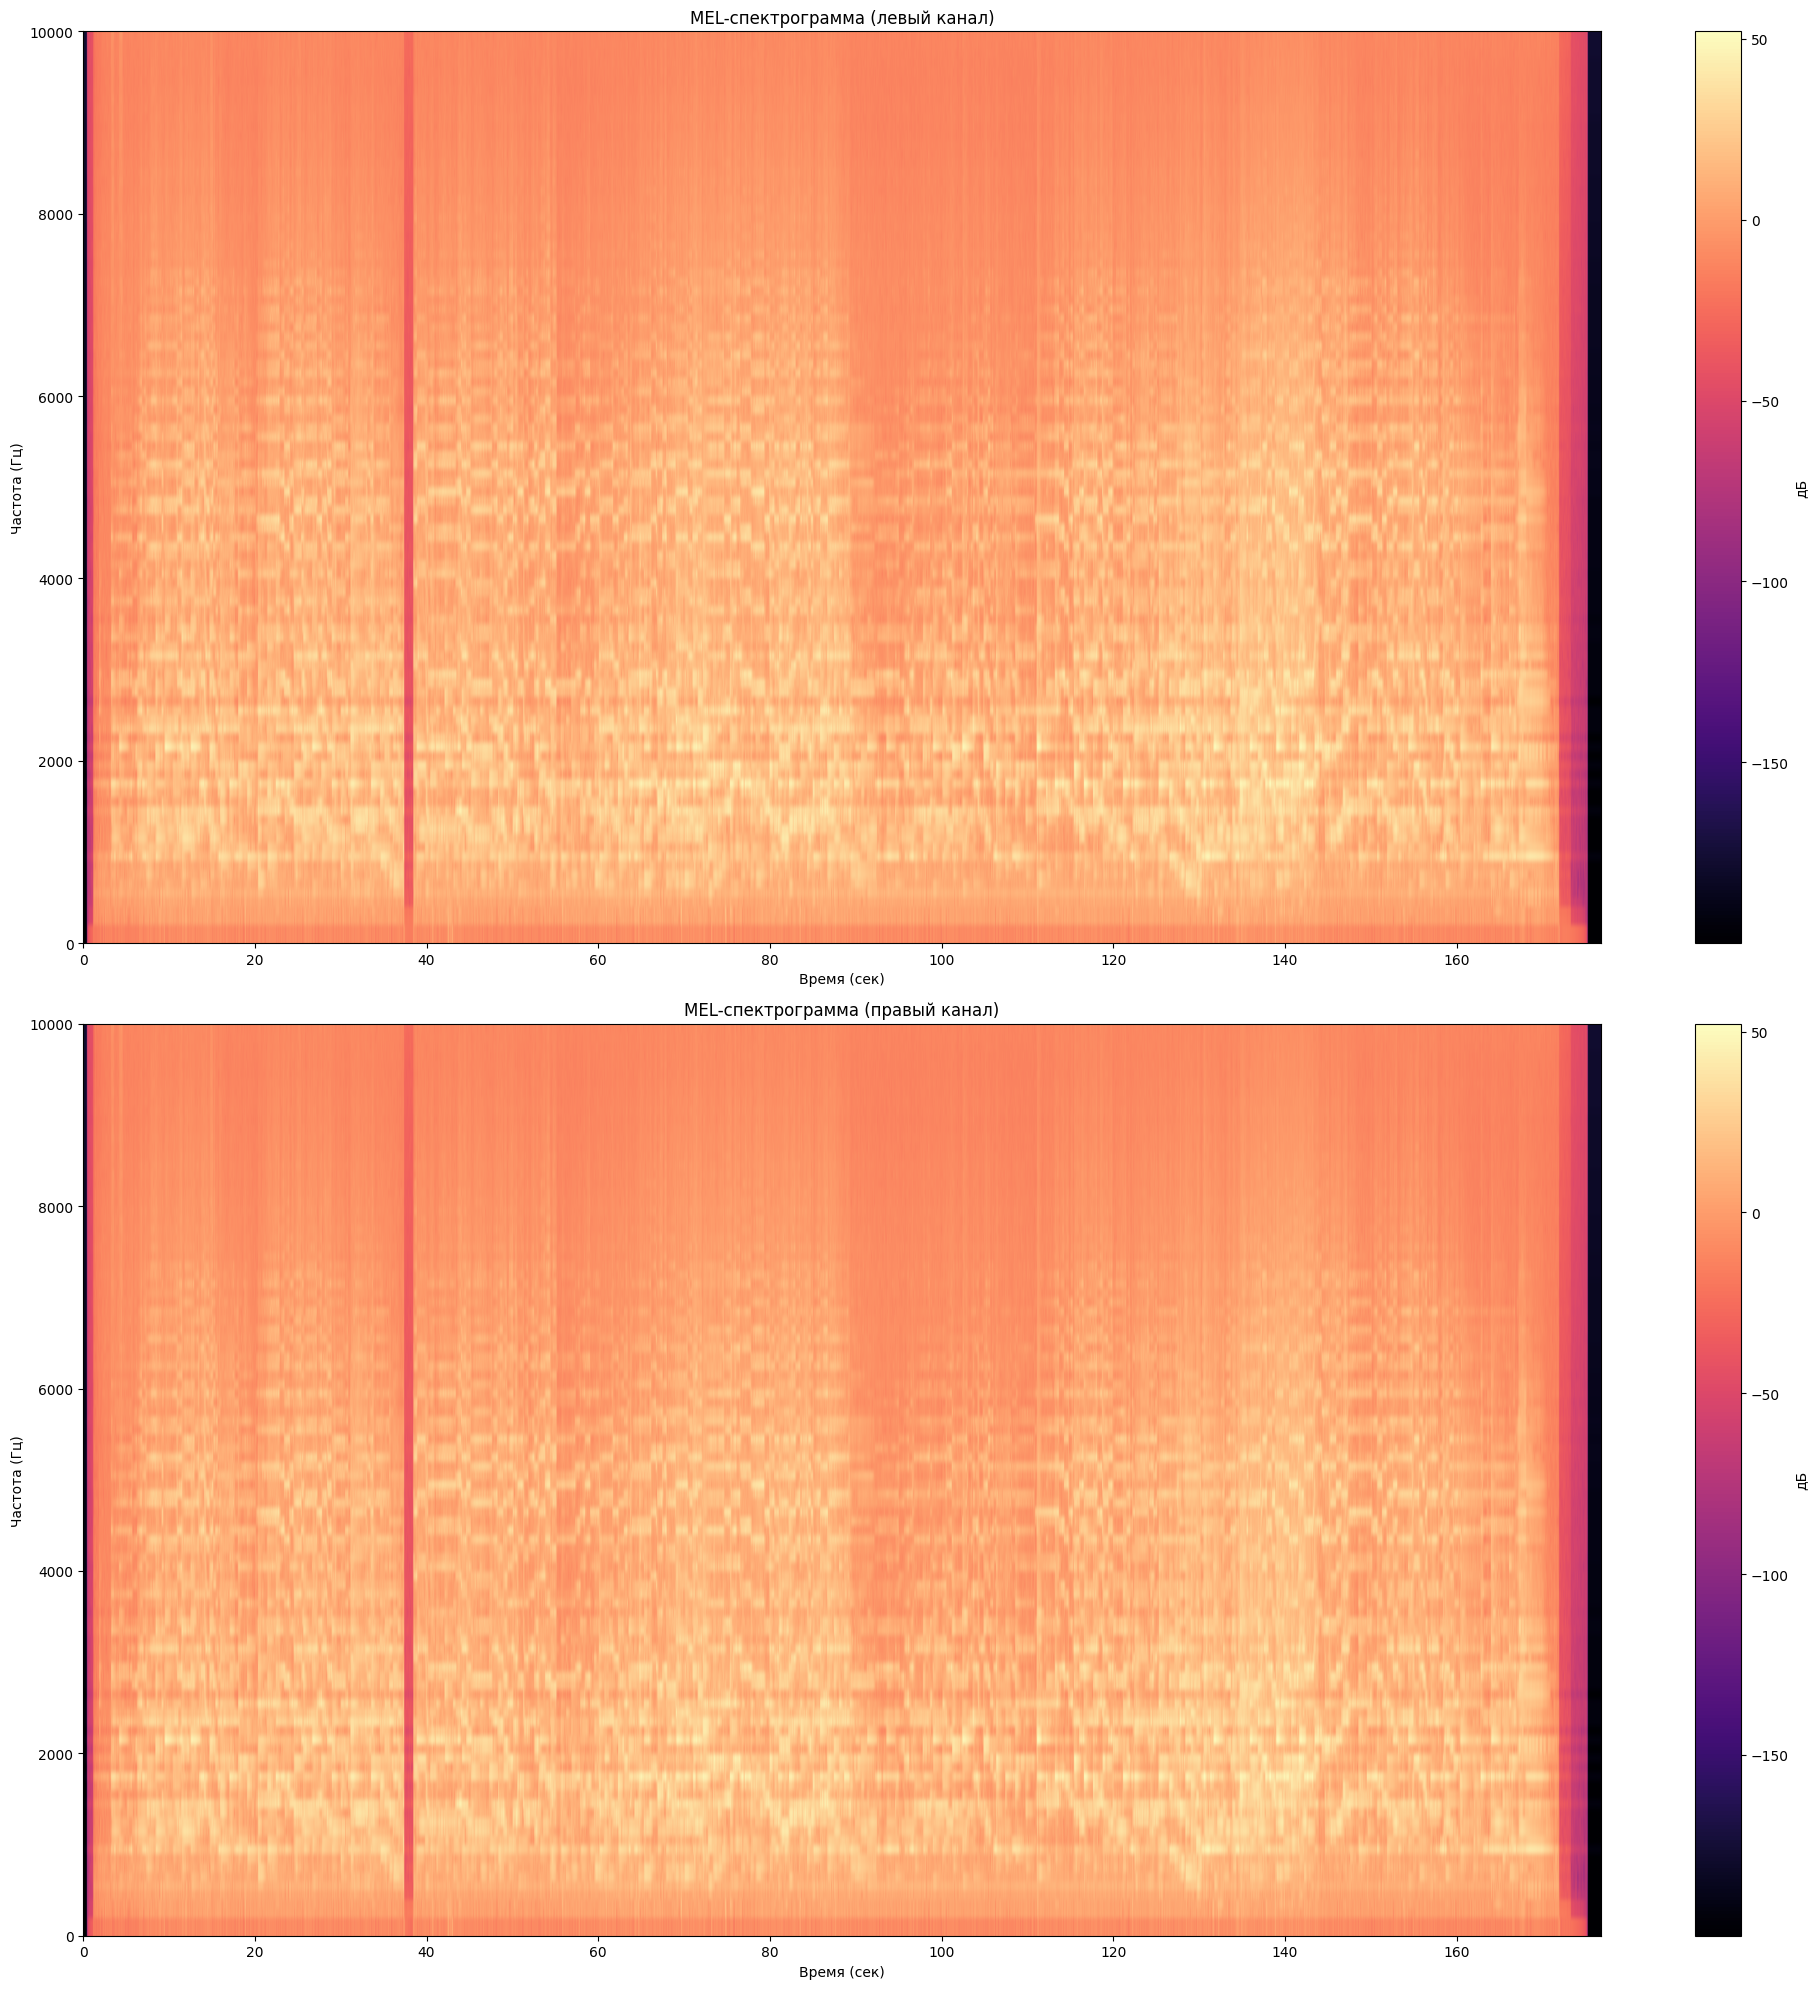

In [51]:
def create_mel_filters(sr, n_fft, n_mels=100, fmin=0, fmax=None):
    if fmax is None:
        fmax = sr / 2

    fmin_mel = hz_to_mel(fmin)
    fmax_mel = hz_to_mel(fmax)

    mel_points = np.linspace(fmin_mel, fmax_mel, n_mels + 2)

    hz_points = mel_to_hz(mel_points)

    fft_bins = np.floor((n_fft + 1) * hz_points / sr).astype(int)

    # Создаем матрицу фильтров
    filters = np.zeros((n_mels, n_fft // 2 + 1))
    for m in range(n_mels):
        left = fft_bins[m]
        center = fft_bins[m + 1]
        right = fft_bins[m + 2]

        if center == left:
            center = left + 1
        if right == center:
            right = center + 1

        if center - left > 0:
            filters[m, left:center] = np.linspace(0, 1, center - left)
        if right - center > 0:
            filters[m, center:right] = np.linspace(1, 0, right - center)

    return filters

def apply_mel_filters(spectrogram, mel_filters):
    # На вход принимает спеткрограмму с амплитудами комплексных чисел
    mel_spectrum = np.dot(mel_filters, spectrogram)
    return mel_spectrum

def plot_mel_spectrograms(mel_left_db, mel_right_db, sr, hop_length, fmin, fmax, size=20):
    """Визуализация MEL-спектрограмм с частотной шкалой"""
    time_left = np.arange(mel_left_db.shape[1]) * hop_length / sr
    time_right = np.arange(mel_right_db.shape[1]) * hop_length / sr

    n_mels = mel_left_db.shape[0]
    fmin_mel = hz_to_mel(fmin)
    fmax_mel = hz_to_mel(fmax)

    mel_points = np.linspace(fmin_mel, fmax_mel, n_mels + 1)
    freq_boundaries = mel_to_hz(mel_points)

    fig, axes = plt.subplots(2, 1, figsize=(size, size))

    im1 = axes[0].imshow(mel_left_db,
                        aspect='auto',
                        origin='lower',
                        cmap='magma',
                        extent=[time_left[0], time_left[-1],
                                freq_boundaries[0], freq_boundaries[-1]])
    axes[0].set_title('MEL-спектрограмма (левый канал)')
    axes[0].set_xlabel('Время (сек)')
    axes[0].set_ylabel('Частота (Гц)')
    plt.colorbar(im1, ax=axes[0], label='дБ')

    im2 = axes[1].imshow(mel_right_db,
                        aspect='auto',
                        origin='lower',
                        cmap='magma',
                        extent=[time_right[0], time_right[-1],
                                freq_boundaries[0], freq_boundaries[-1]])
    axes[1].set_title('MEL-спектрограмма (правый канал)')
    axes[1].set_xlabel('Время (сек)')
    axes[1].set_ylabel('Частота (Гц)')
    plt.colorbar(im2, ax=axes[1], label='дБ')

    plt.tight_layout()
    plt.show()


mel_filters = create_mel_filters(samplerate, n_fft, n_mels, fmin, fmax)
print(mel_filters.shape)

mel_left = apply_mel_filters(spec_left_amp, mel_filters)
mel_left_db = spec_to_db(mel_left, True)

mel_right = apply_mel_filters(spec_right_amp, mel_filters)
mel_right_db = spec_to_db(mel_right, True)

print(mel_left_db.shape, mel_right_db.shape)

plot_mel_spectrograms(mel_left_db, mel_right_db, samplerate, hop_length, fmin, fmax)

Выделим промежуток с 1 по 3 секунду записи и построим для него MEL-спектрограмму

Исходная запись слишком длинная, и на одной спектрограмме сложно увидеть что-либо детальное

(1025, 10770) (1025, 10770)


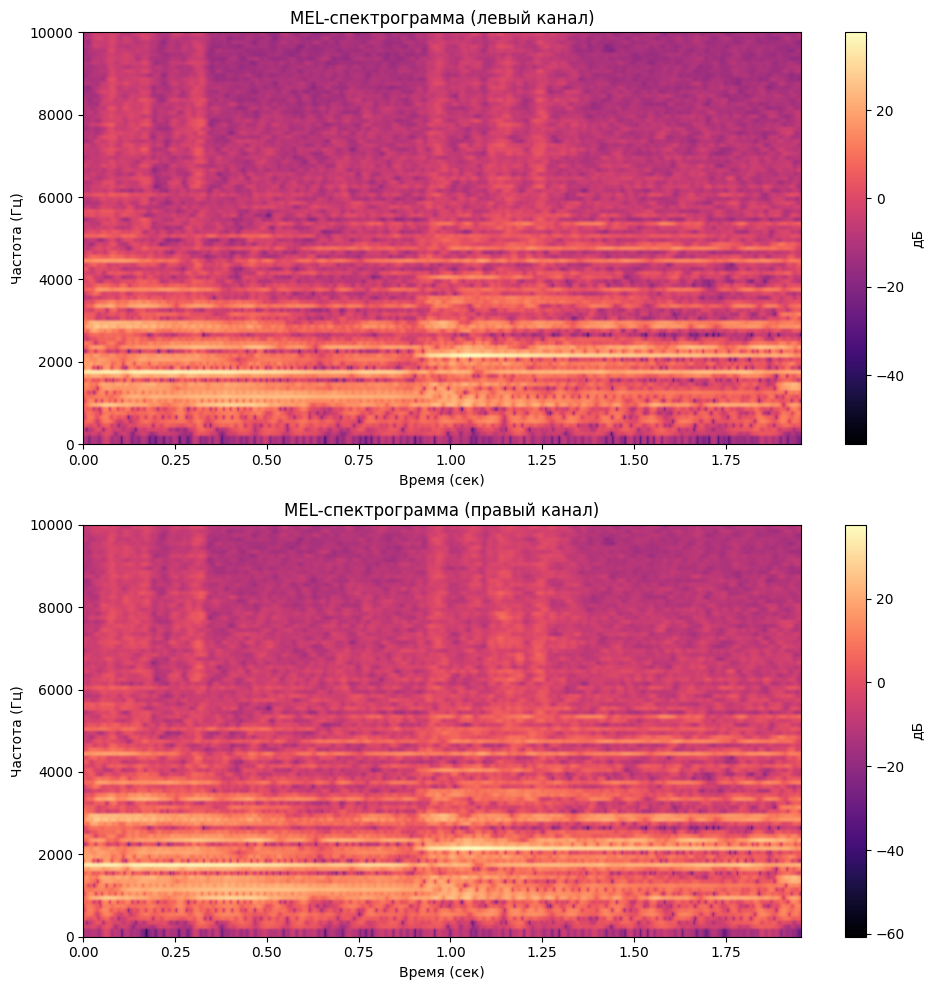

In [56]:
n_fft_new = 2048
hop_length_new = 8

left_channel_two_sec = data[144100:232300, 0]
right_channel_two_sec = data[144100:232300, 1]

spec_left_two_sec = compute_spectrogram(left_channel_two_sec,
                                        n_fft_new, hop_length_new)
spec_right_two_sec = compute_spectrogram(right_channel_two_sec,
                                         n_fft_new, hop_length_new)

print(spec_left_two_sec.shape, spec_right_two_sec.shape)

spec_left_amp_two_sec = spec_to_db(spec_left_two_sec, False)
spec_right_amp_two_sec = spec_to_db(spec_right_two_sec, False)

mel_filters_two_sec = create_mel_filters(samplerate, n_fft_new,
                                         n_mels, fmin, fmax)

mel_left_two_sec = apply_mel_filters(spec_left_amp_two_sec, mel_filters)
mel_left_db_two_sec = spec_to_db(mel_left_two_sec, True)

mel_right_two_sec = apply_mel_filters(spec_right_amp_two_sec, mel_filters)
mel_right_db_two_sec = spec_to_db(mel_right_two_sec, True)

plot_mel_spectrograms(mel_left_db_two_sec, mel_right_db_two_sec,
                      samplerate, hop_length_new, fmin, fmax, size=10)